In [1]:
import os

from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from snewpy import model_path
from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Analytic3Species

from asteria.simulation import Simulation
from asteria import set_rcparams

set_rcparams()
%matplotlib inline

In [2]:
filename = "AnalyticFluenceExample.dat"
model_folder = f"{model_path}/AnalyticFluence/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)
file_path = os.path.join(model_folder, filename)

## Creating a SN model file modelled after the Livermore model

This code was taken from [SNEWS2/snewpy](https://github.com/SNEWS2/snewpy) repository, from the [AnalyticFluence.ipynb](https://github.com/SNEWS2/snewpy/blob/main/doc/nb/AnalyticFluence.ipynb) example notebook.

In [3]:
# These numbers _almost_ reproduce the Livermore model included in the SNOwGLoBES repository.
# They are obtained by calculating the total L, <E> and <E^2> from the livermore.dat
# fluence file (which is modelled after a 10kpc supernova).
total_energy = (5.478e+52, 5.485e+52, 4 * 5.55e+52)
mean_energy = (11.5081, 15.4678, 21.0690)
rms_or_pinch = "rms"
rms_energy = (12.8788, 17.8360, 24.3913)

# Make an astropy table with two times, 0s and 1s, with constant neutrino properties
table = Table()
table['TIME'] = np.linspace(0,1,2)
table['L_NU_E'] =  np.linspace(1,1,2)*total_energy[0]
table['L_NU_E_BAR'] = np.linspace(1,1,2)*total_energy[1]
table['L_NU_X'] = np.linspace(1,1,2)*total_energy[2]/4. #Note, L_NU_X is set to 1/4 of the total NU_X energy
        
table['E_NU_E'] = np.linspace(1,1,2)*mean_energy[0]
table['E_NU_E_BAR'] = np.linspace(1,1,2)*mean_energy[1]
table['E_NU_X'] = np.linspace(1,1,2)*mean_energy[2]

if rms_or_pinch == "rms":
    table['RMS_NU_E'] = np.linspace(1,1,2)*rms_energy[0]
    table['RMS_NU_E_BAR'] = np.linspace(1,1,2)*rms_energy[1]
    table['RMS_NU_X'] = np.linspace(1,1,2)*rms_energy[2]
    table['ALPHA_NU_E'] = (2.0 * table['E_NU_E'] ** 2 - table['RMS_NU_E'] ** 2) / (
        table['RMS_NU_E'] ** 2 - table['E_NU_E'] ** 2)
    table['ALPHA_NU_E_BAR'] = (2.0 * table['E_NU_E_BAR'] ** 2 - table['RMS_NU_E_BAR'] ** 2) / (
        table['RMS_NU_E_BAR'] ** 2 - table['E_NU_E_BAR'] ** 2)
    table['ALPHA_NU_X'] = (2.0 * table['E_NU_X'] ** 2 - table['RMS_NU_X'] ** 2) / (
        table['RMS_NU_X'] ** 2 - table['E_NU_X'] ** 2)
elif rms_or_pinch == "pinch":
    table['ALPHA_NU_E'] = np.linspace(1,1,2)*pinch_values[0]
    table['ALPHA_NU_E_BAR'] = np.linspace(1,1,2)*pinch_values[1]
    table['ALPHA_NU_X'] = np.linspace(1,1,2)*pinch_values[2]
    table['RMS_NU_E'] = np.sqrt((2.0 + table['ALPHA_NU_E'])/(1.0 + table['ALPHA_NU_E'])*table['E_NU_E']**2)
    table['RMS_NU_E_BAR'] =  np.sqrt((2.0 + table['ALPHA_NU_E_BAR'])/(1.0 + table['ALPHA_NU_E_BAR'])*table['E_NU_E_BAR']**2)
    table['RMS_NU_X'] = np.sqrt((2.0 + table['ALPHA_NU_X'])/(1.0 + table['ALPHA_NU_X'])*table['E_NU_X']**2 )
else:
    print("incorrect second moment method: rms or pinch")

table.write(file_path,format='ascii',overwrite=True)

## ASTERIA Simulation

In [4]:
# SNEWPY model dictionary, the format must match the below example for analytic mdoels
model = {
    'name': 'Analytic3Species',
    'param': {
        'filename': file_path
    }
}

sim = Simulation(model=model,
                 distance=10 * u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=-1*u.s,  tmax=10*u.s,    dt=1*u.ms,
                 mixing_scheme='AdiabaticMSW',
                 hierarchy='normal')
sim.run()

No handles with labels found to put in legend.


Text(0, 1.0, 'Total Signal [0.5 s Bins, $\\times 10^{4}$]')

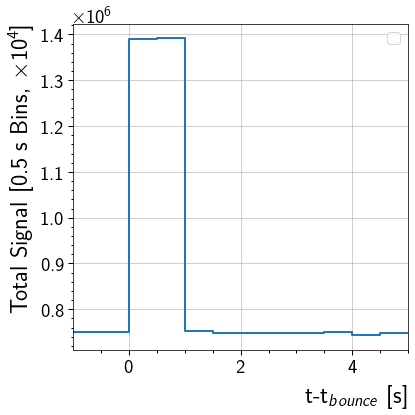

In [5]:
fig, ax = plt.subplots(1, figsize = (6,6))
dt = 0.5 * u.s
scale = 1e4

sim.rebin_result(dt)
t, hits = sim.detector_signal(dt)
bg = sim.detector.i3_bg(dt, size=hits.size) + sim.detector.dc_bg(dt, size=hits.size)


ax.step(t, hits+bg, where='post', lw=2, )
ax.legend()
ax.set(xlim=(-1, 5));
ax.set_xlabel(r't-t$_{bounce}$ [s]', ha='right', x=1.0)
ax.set_ylabel(fr'Total Signal [{dt} Bins, $\times 10^{{{int(np.log10(scale))}}}$]', ha='right', y=1.0)